## Analysis of SF311 data regarding human and animal wastes 

Human waste is a serious health issue in San Francisco, California. It is a bit of a paradox: There are few bathrooms open after 10 p.m. in the city, and yet, public defecation and urination are criminalized for the large homeless population in the famously expensive city. 

This map identifies neighborhoods with the most waste, which is an indicator of homelessness in San Francisco, for 2019. This was a record year for amount of wastes in the city (refer to Part1 analysis). 

In order to create the map, our team analyzed non-emergency 311 calls regarding human and animal wastes to San Francisco city. It should be noted that 311 calls cannot differentiate from human and animal waste.

In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

## Initial data vetting

This data originally came from 311 calls data on San Francisco open data portal. The data was vetted through DB Browser for SQLite, which allowed us to filter for RequestType that corresponds to human and animal waste calls. We saved the file as "human_animal_waste_311.csv" and used it for our analysis below. 

Original data source: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6

Below is the SQL query we used to vet data: 

CREATE TABLE human_animal_waste_311 AS

SELECT CaseID, Opened, RequestType, Neighborhood, Latitude, Longitude

FROM "311_Cases"

WHERE (RequestType LIKE 'Human/Animal Waste') OR (RequestType LIKE 'Human%Animal Waste')

In [4]:
import os
data_dir = os.environ['DATA_DIR']
waste_fp = os.path.join(data_dir, 'processed', 'human_animal_waste_311.csv')
with open(waste_fp, 'r') as source_file:
    text = source_file.read()

In [5]:
waste = pd.read_csv(waste_fp)
waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163435 entries, 0 to 163434
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CaseID        163435 non-null  int64  
 1   Opened        163435 non-null  object 
 2   RequestType   163435 non-null  object 
 3   Neighborhood  161512 non-null  object 
 4   Latitude      163435 non-null  float64
 5   Longitude     163435 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 7.5+ MB


##  Data analysis

We wanted to focus on requests that came in during 2019, which was the year with the highest amount of waste overall. In order to do so, we first extracted the "year" from the "Opened" column (which includes the full date for when the request came in) and created a new column.

In [6]:
waste['year'] = pd.DatetimeIndex(waste['Opened']).year
waste.info() # this shows new "year" column at the end 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163435 entries, 0 to 163434
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CaseID        163435 non-null  int64  
 1   Opened        163435 non-null  object 
 2   RequestType   163435 non-null  object 
 3   Neighborhood  161512 non-null  object 
 4   Latitude      163435 non-null  float64
 5   Longitude     163435 non-null  float64
 6   year          163435 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 8.7+ MB


We then selected the columns that we wanted to keep. 

In [7]:
waste_trunc = waste[['CaseID','Neighborhood','RequestType','Latitude','Longitude','year']] 
waste_trunc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163435 entries, 0 to 163434
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CaseID        163435 non-null  int64  
 1   Neighborhood  161512 non-null  object 
 2   RequestType   163435 non-null  object 
 3   Latitude      163435 non-null  float64
 4   Longitude     163435 non-null  float64
 5   year          163435 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 7.5+ MB


Below, we filtered for calls that were requested in 2019. 

In [8]:
waste_2019 = waste_trunc['year']==2019
waste_2019_list = waste_trunc[waste_2019]
waste_2019_list.head()

,CaseID,Neighborhood,RequestType,Latitude,Longitude,year
0,10858769,Civic Center,Human or Animal Waste,37.781504,-122.417337,2019
33,11707729,Lower Nob Hill,Human or Animal Waste,37.787155,-122.412355,2019
80,11864728,Bernal Heights,Human or Animal Waste,37.741352,-122.421795,2019
106,11881905,Mission,Human or Animal Waste,37.769627,-122.417007,2019
107,11881911,South of Market,Human or Animal Waste,37.774436,-122.420334,2019


We grouped the data by neighborhood to see the sum of calls regarding wastes for each neighborhood. 

In [56]:
waste_by_area = waste_2019_list.fillna("None").groupby('Neighborhood').count()
waste_by_area['count'] = waste_by_area['CaseID']
waste_by_area = waste_by_area[['count']] 
waste_by_area.head()

,count
Neighborhood,
Alamo Square,109
Anza Vista,27
Apparel City,39
Aquatic Park / Ft. Mason,37
Ashbury Heights,23


## Data visualization

In order to create a map, we downloaded the San Francisco neighborhood map in shape file from the same open data portal.

Shape file source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

In [10]:
data_dir = os.environ['DATA_DIR']
sf_shape_fp = os.path.join(data_dir, 'raw', 'sf_neighborhoods.shp')
with open(sf_shape_fp, 'rb') as source_file:
    text = source_file.read()

In [11]:
sf_shape = gpd.read_file(sf_shape_fp)

In [12]:
sf_shape.head()

,nhood,geometry
0,Bayview Hunters Point,"POLYGON ((-122.38158 37.75307, -122.38157 37.7..."
1,Bernal Heights,"POLYGON ((-122.40361 37.74934, -122.40378 37.7..."
2,Castro/Upper Market,"POLYGON ((-122.42656 37.76948, -122.42695 37.7..."
3,Chinatown,"POLYGON ((-122.40623 37.79756, -122.40551 37.7..."
4,Excelsior,"POLYGON ((-122.42398 37.73155, -122.42392 37.7..."


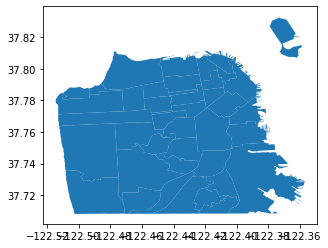

In [13]:
sf_shape.plot()

Creating a map requires joining the shape file with our csv file. To do so, we created a new column called "Neighborhood" for our shape file.

In [14]:
sf_shape['Neighborhood'] = sf_shape['nhood']

We then joined the two files on the column "Neighborhood."

In [59]:
joined = sf_shape.merge(
    waste_by_area,
    on = "Neighborhood",
    how = "left",
)

In [60]:
joined.head()

,nhood,geometry,Neighborhood,count
0,Bayview Hunters Point,"POLYGON ((-122.38158 37.75307, -122.38157 37.7...",Bayview Hunters Point,NaN
1,Bernal Heights,"POLYGON ((-122.40361 37.74934, -122.40378 37.7...",Bernal Heights,264.0
2,Castro/Upper Market,"POLYGON ((-122.42656 37.76948, -122.42695 37.7...",Castro/Upper Market,NaN
3,Chinatown,"POLYGON ((-122.40623 37.79756, -122.40551 37.7...",Chinatown,546.0
4,Excelsior,"POLYGON ((-122.42398 37.73155, -122.42392 37.7...",Excelsior,92.0


In [61]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   nhood         41 non-null     object  
 1   geometry      41 non-null     geometry
 2   Neighborhood  41 non-null     object  
 3   count         31 non-null     float64 
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.6+ KB


Sorting values revealed that South of Market had the highest number of calls regarding human and animal wastes (6416 calls), followed by Mission (4148 calls) and Tenderloin (2127 calls).

In [62]:
joined.sort_values("count", ascending = False).head().reset_index()

,index,nhood,geometry,Neighborhood,count
0,27,South of Market,"POLYGON ((-122.40371 37.78404, -122.40271 37.7...",South of Market,6416.0
1,20,Mission,"POLYGON ((-122.41096 37.76943, -122.41093 37.7...",Mission,4148.0
2,14,Tenderloin,"POLYGON ((-122.41917 37.77528, -122.41926 37.7...",Tenderloin,2127.0
3,25,North Beach,"MULTIPOLYGON (((-122.41152 37.81045, -122.4115...",North Beach,801.0
4,33,Potrero Hill,"POLYGON ((-122.38487 37.76724, -122.38485 37.7...",Potrero Hill,772.0


Below is a choropleth map of the human and animal waste 311 calls made in 2019, with darker shades corresponding to more calls. The darkest three are South of Market, Mission and Tenderloin. 

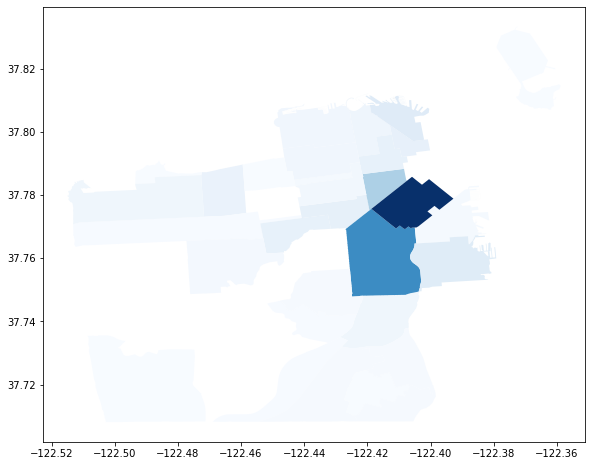

In [71]:
joined.plot(
    column = 'count', 
    cmap = 'Blues',
    figsize=(16, 8)
)

##  Additional question: What about 2009?
Since our Part1 analysis goes back to as far as 2009, we decided to see if the top three areas with the most calls about human and animal waste were different back then. Proce

In [64]:
waste_2009 = waste_trunc['year']==2009
waste_2009_list = waste_trunc[waste_2009]
waste_2009_list.head()

,CaseID,Neighborhood,RequestType,Latitude,Longitude,year
1,571562,North Beach,Human or Animal Waste,37.800602,-122.407898,2009
2,571550,North Beach,Human or Animal Waste,37.799664,-122.407700,2009
3,571546,North Beach,Human or Animal Waste,37.799702,-122.407394,2009
4,571501,South of Market,Human or Animal Waste,37.781754,-122.409691,2009
6,570884,Tenderloin,Human or Animal Waste,37.783150,-122.409508,2009


In [65]:
waste_by_area_2009 = waste_2009_list.fillna("None").groupby('Neighborhood').count()
waste_by_area_2009['count'] = waste_by_area_2009['CaseID']
waste_by_area_2009 = waste_by_area_2009[['count']] 
waste_by_area_2009.head()

,count
Neighborhood,
Alamo Square,2
Anza Vista,3
Aquatic Park / Ft. Mason,4
Bayview,59
Bernal Heights,13


In [66]:
joined_2009 = sf_shape.merge(
    waste_by_area_2009,
    on = "Neighborhood",
    how = "left",
)

In [67]:
joined_2009.sort_values("count", ascending = False).head().reset_index()

,index,nhood,geometry,Neighborhood,count
0,14,Tenderloin,"POLYGON ((-122.41917 37.77528, -122.41926 37.7...",Tenderloin,1948.0
1,27,South of Market,"POLYGON ((-122.40371 37.78404, -122.40271 37.7...",South of Market,816.0
2,20,Mission,"POLYGON ((-122.41096 37.76943, -122.41093 37.7...",Mission,685.0
3,25,North Beach,"MULTIPOLYGON (((-122.41152 37.81045, -122.4115...",North Beach,84.0
4,4,Excelsior,"POLYGON ((-122.42398 37.73155, -122.42392 37.7...",Excelsior,58.0


This reveals that the top three neighborhoods were still dominant in 2009, but the order changed. Tenderloin was at the highest with 1948 calls, followed by South of Market (816 calls), then Mission (685 calls). Calls about wastes in Tenderloin were much higher than either of the two – more than twice the second place, South of Market, and nearly three times  the third place, Mission.

Another interesting aspect to note is that the raw counts of calls by neighborhood seem to be much higher for the top three neighborhoods in 2019 compared to 2009. 

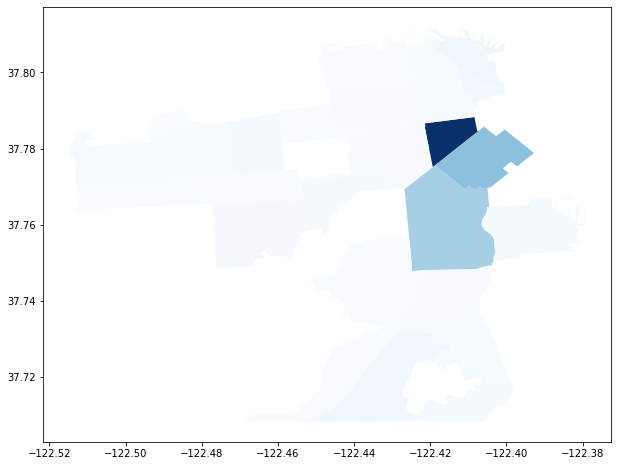

In [70]:
joined_2009.plot(
    column = 'count', 
    cmap = 'Blues',
    figsize=(16, 8)
)